<a href="https://colab.research.google.com/github/AbdilahiMJama/3D-Object-Detection-from-the-KITTI-dataset/blob/main/PointNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pykitti

# All Imports

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import os
import pykitti
from drive.MyDrive.ColabNotebooks.parseTrackletXML import *
import math
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms,utils
from pathlib import Path



# Getting Information about the dataset

In [ ]:
image_files = '/content/drive/MyDrive/2011_09_26_drive_0015_sync/2011_09_26/2011_09_26_drive_0015_sync'

# Colored left and right images
right_image_path = sorted(glob(os.path.join(image_files,'image_02/data/*.png')))
left_image_path = sorted(glob(os.path.join(image_files,'image_03/data/*.png')))

# LiDAR Data
bin_path = sorted(glob(os.path.join(image_files,'velodyne_points/data/*.bin')))

print(f'Number of right images: ', {len(right_image_path)})
print(f'Number of right images: ', {len(left_image_path)})
print(f'Number of right images: ', {len(bin_path)})

Number of right images:  {297}
Number of right images:  {297}
Number of right images:  {297}


## Setup the file structure to match Pykitti's raw dataset parser

## Load the dataset using pykitti raw

In [5]:
def load_dataset(date,drive,calibrated=False,frame_range=None):
    '''
    Load the dataset from the KITTI raw dataset with the help of pykitti library
    :param date: Date of the drive
    :param drive: Drive number
    :param calibrated: If the dataset is calibrated
    :param frame_range: Range of frames to load
    :return: dataset
    '''

    dataset = pykitti.raw(basedir,date,drive)
    if calibrated:
        dataset._load_calib()
    np.set_printoptions(precision=4, suppress=True)
    print('\nDrive: ' + str(dataset.drive))
    print('\nFrame range: ' + str(dataset.frames))

    if calibrated:
        print('\nIMU-to-Velodyne transformation:\n' + str(dataset.calib.T_velo_imu))
        print('\nGray stereo pair baseline: [m]\n' + str(dataset.calib.b_gray))
        print('\nRGB stereo pair baseline [m]:\n' + str(dataset.calib.b_rgb))
    return dataset

In [6]:
basedir = '/content/drive/MyDrive/2011_09_26_drive_0015_sync'
date = '2011_09_26'
drive = '0015'
dataset = load_dataset(date,drive,True)


Drive: 2011_09_26_drive_0015_sync

Frame range: None

IMU-to-Velodyne transformation:
[[ 1.      0.0008 -0.002  -0.8087]
 [-0.0008  0.9999 -0.0148  0.3196]
 [ 0.002   0.0148  0.9999 -0.7997]
 [ 0.      0.      0.      1.    ]]

Gray stereo pair baseline: [m]
0.537150600500771

RGB stereo pair baseline [m]:
0.5327254400790535


## Viewing the image from the dataset

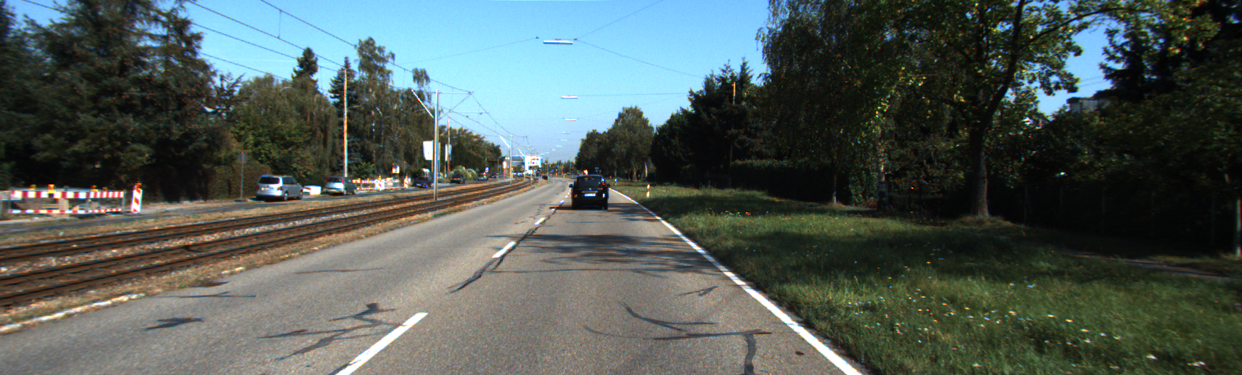

In [7]:
dataset.get_cam2(0)

In [12]:
dataset.get_velo(1).shape

(123789, 4)

## Loading the tracklets, which are objects containing the dimensions of the bounding boxes for each image and LiDAR point cloud

In [14]:
def load_tracklets(n_frames, xml_path):
    '''
    Load the tracklets from the xml file
    :param n_frames: Number of frames
    :param xml_path: Path to the xml file
    :return: frame_tracklets, frame_tracklets_types
    '''
    tracklets = parseXML(xml_path)
    frame_tracklets = {}
    frame_tracklets_types = {}
    for i in range(n_frames):
        frame_tracklets[i] = []
        frame_tracklets_types[i] = []

    for i, tracklet in enumerate(tracklets):
        h,w,l = tracklet.size
        #print(h,w,l)
        trackletBox = np.array([[-l / 2, -l / 2, l / 2, l / 2, -l / 2, -l / 2, l / 2, l / 2],
            [w / 2, -w / 2, -w / 2, w / 2, w / 2, -w / 2, -w / 2, w / 2],
            [0.0, 0.0, 0.0, 0.0, h, h, h, h]])
        for translation,rotation,state,occlusion,truncation,amtOcclusion,amtBorders,absoluteFrameNumber in tracklet:
            if truncation not in (TRUNC_IN_IMAGE, TRUNC_TRUNCATED):
                continue
            yaw = rotation[2]   # other rotations are 0 in all xml files I checked
            assert np.abs(rotation[:2]).sum() == 0, 'object rotations other than yaw given!'
            rotMat = np.array([\
                [np.cos(yaw), -np.sin(yaw), 0.0], \
                [np.sin(yaw),  np.cos(yaw), 0.0], \
                [0.0,0.0, 1.0]])
            cornerPosInVelo = np.dot(rotMat, trackletBox) + np.tile(translation, (8,1)).T
            #print(frame_tracklets)
            frame_tracklets[absoluteFrameNumber] = frame_tracklets[absoluteFrameNumber] + [cornerPosInVelo]
            frame_tracklets_types[absoluteFrameNumber] = frame_tracklets_types[absoluteFrameNumber]+[tracklet.objectType]

    return (frame_tracklets, frame_tracklets_types)

## Getting the tracklet types and their bounding boxes in a dictionary

In [15]:
tracklet_rects, tracklet_types = load_tracklets(len(list(dataset.velo)),'/content/drive/MyDrive/2011_09_26_drive_0015_sync/2011_09_26/tracklet_labels.xml'.format(date))

parsing tracklet file /content/drive/MyDrive/2011_09_26_drive_0015_sync/2011_09_26/tracklet_labels.xml
file contains 36 tracklets
loaded 36 tracklets


In [16]:
len(tracklet_rects)

297

In [17]:
tracklet_rects[0],tracklet_types[0]

([array([[45.0373, 44.9851, 48.5252, 48.5773, 45.0373, 44.9851, 48.5252,
          48.5773],
         [22.0835, 20.4563, 20.3428, 21.9701, 22.0835, 20.4563, 20.3428,
          21.9701],
         [-1.2625, -1.2625, -1.2625, -1.2625,  0.4535,  0.4535,  0.4535,
           0.4535]]),
  array([[56.0829, 56.126 , 59.6329, 59.5898, 56.0829, 56.126 , 59.6329,
          59.5898],
         [22.1987, 20.6956, 20.7961, 22.2992, 22.1987, 20.6956, 20.7961,
          22.2992],
         [-1.0296, -1.0296, -1.0296, -1.0296,  0.4911,  0.4911,  0.4911,
           0.4911]]),
  array([[32.8212, 32.8603, 37.359 , 37.3199, 32.8212, 32.8603, 37.359 ,
          37.3199],
         [ 1.6945,  0.0661,  0.174 ,  1.8025,  1.6945,  0.0661,  0.174 ,
           1.8025],
         [-1.3781, -1.3781, -1.3781, -1.3781,  0.2439,  0.2439,  0.2439,
           0.2439]])],
 ['Car', 'Car', 'Car'])

In [ ]:
'''class PointCloudData(Dataset):
    def __init__(self, root_dir, tracklets_info, transform=None):
        self.root_dir = Path(root_dir)
        self.tracklets_info = tracklets_info
        self.transform = transform

        self.files = [f for f in sorted(os.listdir(root_dir)) if f.endswith('.bin')]

    def __len__(self):
        return len(self.files)

    def __preproc__(self, file_path):
        pointcloud = np.fromfile(file_path, dtype=np.float32).reshape(-1, 4)
        if self.transform:
            pointcloud = self.transform(pointcloud)
        return pointcloud

    def __getitem__(self, idx):
        frame = self.files[idx]
        frame_num = int(frame.split('.')[0])
        pcd_path = self.root_dir / frame

        pointcloud = self.__preproc__(pcd_path)
        bounding_boxes = self.tracklets_info[0].get(frame_num, [])
        labels = self.tracklets_info[1].get(frame_num, [])

        return {'pointcloud': pointcloud[:, :3], 'bounding_boxes': bounding_boxes, 'labels': labels}
'''
class PointCloudData(Dataset):
    def __init__(self, root_dir, tracklets_info, valid=False, folder="train", transform=None):
        self.root_dir = Path(root_dir)
        self.tracklets_info = tracklets_info
        self.transform = transform if not valid else None
        self.valid = valid

        # Gather all binary files and their corresponding frame numbers
        self.files = []
        for file in sorted(os.listdir(self.root_dir)):
            if file.endswith('.bin'):
                frame_num = int(file.split('.')[0])
                sample = {
                    'pcd_path': self.root_dir / file,
                    'frame_num': frame_num
                }
                self.files.append(sample)

    def __len__(self):
        return len(self.files)

    def __preproc__(self, file_path):
        # Load the point cloud from the .bin file
        pointcloud = np.fromfile(file_path, dtype=np.float32).reshape(-1, 4)
        if self.transform:
            pointcloud = self.transform(pointcloud)
        return pointcloud

    def __getitem__(self, idx):
        sample = self.files[idx]
        pcd_path = sample['pcd_path']
        frame_num = sample['frame_num']

        # Preprocess point cloud
        pointcloud = self.__preproc__(pcd_path)

        # Get bounding boxes and labels from tracklets_info
        bounding_boxes = self.tracklets_info[0].get(frame_num, [])
        labels = self.tracklets_info[1].get(frame_num, [])

        return {
            'pointcloud': pointcloud[:, :3],  # Use only the x, y, z coordinates
            'bounding_boxes': bounding_boxes,
            'labels': labels
        }

In [ ]:
'''def custom_collate_fn(batch):
    # Determine the maximum number of points in a batch
    max_points = max(item['pointcloud'].shape[0] for item in batch)

    # Pad point clouds and bounding boxes to the maximum number of points
    pointclouds = []
    for item in batch:
        pc = torch.tensor(item['pointcloud'])
        if pc.shape[0] < max_points:
            padding = torch.zeros((max_points - pc.shape[0], 3))
            pc = torch.cat([pc, padding], dim=0)
        pointclouds.append(pc)
    pointclouds = torch.stack(pointclouds)

    bounding_boxes = [torch.tensor(item['bounding_boxes']) for item in batch]

    # Convert labels from string to indices
    labels = [item['labels'] for item in batch]
    class_to_label = {'Car': 0, 'Pedestrian': 1, 'Cyclist': 2}
    max_len = max(len(lbls) for lbls in labels)
    padded_labels = [[class_to_label.get(lbl, -1) for lbl in lbls] + [-1] * (max_len - len(lbls)) for lbls in labels]
    labels_tensor = torch.tensor(padded_labels)

    return {'pointclouds': pointclouds, 'bounding_boxes': bounding_boxes, 'labels': labels_tensor}
'''


In [ ]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F

class Tnet(nn.Module):
   def __init__(self, k=3):
      super().__init__()
      self.k=k
      self.conv1 = nn.Conv1d(k,64,1)
      self.conv2 = nn.Conv1d(64,128,1)
      self.conv3 = nn.Conv1d(128,1024,1)
      self.fc1 = nn.Linear(1024,512)
      self.fc2 = nn.Linear(512,256)
      self.fc3 = nn.Linear(256,k*k)

      self.bn1 = nn.BatchNorm1d(64)
      self.bn2 = nn.BatchNorm1d(128)
      self.bn3 = nn.BatchNorm1d(1024)
      self.bn4 = nn.BatchNorm1d(512)
      self.bn5 = nn.BatchNorm1d(256)


   def forward(self, input):
      # input.shape == (bs,n,3)
      bs = input.size(0)
      xb = F.relu(self.bn1(self.conv1(input)))
      xb = F.relu(self.bn2(self.conv2(xb)))
      xb = F.relu(self.bn3(self.conv3(xb)))
      pool = nn.MaxPool1d(xb.size(-1))(xb)
      flat = nn.Flatten(1)(pool)
      xb = F.relu(self.bn4(self.fc1(flat)))
      xb = F.relu(self.bn5(self.fc2(xb)))

      #initialize as identity
      init = torch.eye(self.k, requires_grad=True).repeat(bs,1,1)
      if xb.is_cuda:
        init=init.cuda()
      matrix = self.fc3(xb).view(-1,self.k,self.k) + init
      return matrix


class Transform(nn.Module):
   def __init__(self):
        super().__init__()
        self.input_transform = Tnet(k=3)
        self.feature_transform = Tnet(k=64)
        self.conv1 = nn.Conv1d(3,64,1)

        self.conv2 = nn.Conv1d(64,128,1)
        self.conv3 = nn.Conv1d(128,1024,1)


        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)

   def forward(self, input):
        matrix3x3 = self.input_transform(input)
        # batch matrix multiplication
        xb = torch.bmm(torch.transpose(input,1,2), matrix3x3).transpose(1,2)

        xb = F.relu(self.bn1(self.conv1(xb)))

        matrix64x64 = self.feature_transform(xb)
        xb = torch.bmm(torch.transpose(xb,1,2), matrix64x64).transpose(1,2)

        xb = F.relu(self.bn2(self.conv2(xb)))
        xb = self.bn3(self.conv3(xb))
        xb = nn.MaxPool1d(xb.size(-1))(xb)
        output = nn.Flatten(1)(xb)
        return output, matrix3x3, matrix64x64

class PointNet(nn.Module):
    def __init__(self, classes = 10):
        super().__init__()
        self.transform = Transform()
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, classes)


        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout = nn.Dropout(p=0.3)
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, input):
        xb, matrix3x3, matrix64x64 = self.transform(input)
        xb = F.relu(self.bn1(self.fc1(xb)))
        xb = F.relu(self.bn2(self.dropout(self.fc2(xb))))
        output = self.fc3(xb)
        return self.logsoftmax(output), matrix3x3, matrix64x64

In [ ]:
from torch.utils.data import Dataset, DataLoader, random_split
# Hyperparameters
num_classes = 3  # Car, Cyclist, Van
learning_rate = 0.001
num_epochs = 10

# Initialize model, criterion, optimizer
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
pointnet = PointNet(num_classes)
pointnet.to(device);
optimizer = torch.optim.Adam(pointnet.parameters(), lr=0.001)


# Create dataset and dataloader
# Load tracklet information
n_frames = len(os.listdir('/content/drive/MyDrive/2011_09_26_drive_0015_sync/2011_09_26/2011_09_26_drive_0015_sync/velodyne_points/data/'))  # assuming each file is a frame
xml_path = '/content/drive/MyDrive/2011_09_26_drive_0015_sync/2011_09_26/tracklet_labels.xml'
tracklets_info = load_tracklets(n_frames, xml_path)

# Create dataset and dataloader
dataset = PointCloudData(root_dir='/content/drive/MyDrive/2011_09_26_drive_0015_sync/2011_09_26/2011_09_26_drive_0015_sync/velodyne_points/data/', tracklets_info=tracklets_info)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size,test_size])

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True,collate_fn=custom_collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=True,collate_fn=custom_collate_fn)


parsing tracklet file /content/drive/MyDrive/2011_09_26_drive_0015_sync/2011_09_26/tracklet_labels.xml
file contains 36 tracklets
loaded 36 tracklets


In [ ]:
len(dataset.tracklets_info[0][0])

3

In [ ]:
def train(model, train_loader, val_loader=None, epochs=15, save=True):
    criterion = torch.nn.NLLLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data['pointclouds'].to(device).float(), data['labels'].to(device)
            optimizer.zero_grad()
            outputs, m3x3, m64x64 = model(inputs.transpose(1, 2))

            # Calculate loss
            bs = outputs.size(0)
            id3x3 = torch.eye(3, requires_grad=True).repeat(bs, 1, 1).to(device)
            id64x64 = torch.eye(64, requires_grad=True).repeat(bs, 1, 1).to(device)
            diff3x3 = id3x3 - torch.bmm(m3x3, m3x3.transpose(1, 2))
            diff64x64 = id64x64 - torch.bmm(m64x64, m64x64.transpose(1, 2))
            loss = criterion(outputs, labels) + 0.0001 * (torch.norm(diff3x3) + torch.norm(diff64x64)) / float(bs)

            loss.backward()
            optimizer.step()

            # Print statistics
            running_loss += loss.item()
            if i % 10 == 9:    # Print every 10 mini-batches
                print('[Epoch: %d, Batch: %4d / %4d], loss: %.3f' %
                      (epoch + 1, i + 1, len(train_loader), running_loss / 10))
                running_loss = 0.0

        model.eval()
        correct = total = 0

        # Validation
        if val_loader:
            with torch.no_grad():
                for data in val_loader:
                    inputs, labels = data['pointclouds'].to(device).float(), data['labels'].to(device)
                    outputs, _, _ = model(inputs.transpose(1, 2))
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
            val_acc = 100. * correct / total
            print('Valid accuracy: %d %%' % val_acc)

        # Save the model
        if save:
            torch.save(model.state_dict(), f"save_{epoch}.pth")


In [ ]:
train(pointnet, train_dataloader, test_dataloader, epochs=num_epochs, save=True)

<ipython-input-13-fff4ef4d4213>:15: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  bounding_boxes = [torch.tensor(item['bounding_boxes']) for item in batch]


RuntimeError: 0D or 1D target tensor expected, multi-target not supported

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
pointnet = PointNet()
pointnet.load_state_dict(torch.load('save.pth'))
pointnet.eval();

FileNotFoundError: [Errno 2] No such file or directory: 'save.pth'